In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [5]:
# READ IN ALL DATA
ticker = 'AMC'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,34.0,8.0,42.0,19.047574,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,7.0,1.0,8.0,12.499844,0,41.0,20.5,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,3.0,1.0,4.0,24.999375,0,10.0,5.0,-91.176471,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.000000,0,3.0,1.5,-100.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788105,0,-0.238123
4,2021-01-05,0.0,0.0,0.0,0.000000,0,0.0,0.0,-100.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815720,1,-0.203684


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     339 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [7]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '7D%Change', 'SD_log', 'SD', '6Dir', 'Open', '5Dir', 'Low', 'High', '4Dir', 'Dir', '3Dir', '2D%Change', 'Daily%Change', '6D%Change', 'Volume', '3D%Change', '2Dir', '4D%Change', '7Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,3Dir(t-1),2D%Change(t-1),Daily%Change(t-1),6D%Change(t-1),Volume(t-1),3D%Change(t-1),2Dir(t-1),4D%Change(t-1),7Dir(t-1),Close(t-1)
10,3.06,1,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,1.0,6.880727,6.880727,13.658536,162356400.0,1.746723,1.0,5.909085,1.0,2.33
11,2.97,2,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,1.0,40.366966,31.330474,42.990645,256276000.0,40.366966,1.0,33.624454,1.0,3.06
12,2.98,3,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,1.0,27.467817,-2.941174,34.999998,181862200.0,36.238529,1.0,36.238529,1.0,2.97
13,3.51,4,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,1.0,-2.614377,0.336700,30.131007,64823800.0,27.897001,0.0,36.697244,1.0,2.98
14,4.42,0,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,1.0,18.181817,17.785234,61.009169,268273400.0,14.705884,1.0,50.643781,1.0,3.51


In [8]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,2D%Change(t-1),Daily%Change(t-1),6D%Change(t-1),Volume(t-1),3D%Change(t-1),2Dir(t-1),4D%Change(t-1),7Dir(t-1),Close(t-1),Prediction
231,30.280001,3,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,-22.448427,-15.822036,-30.722603,63296100.0,-24.076538,0.0,-26.536384,0.0,28.570000,30.280001
233,28.790001,0,24.0,8.0,32.0,24.999922,226.0,113.0,100.000000,33.0,...,1.540079,-4.194189,-25.404987,66188600.0,-14.525629,1.0,-21.254071,0.0,29.010000,28.790001
235,32.349998,2,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,6.997589,7.815213,-15.743755,47927100.0,2.509908,1.0,8.645437,0.0,31.040001,32.349998
237,27.440001,4,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,-5.090212,-8.933538,3.115154,36556800.0,2.327191,0.0,1.551185,0.0,29.459999,27.440001
245,28.680000,2,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,4.052192,2.020197,30.378655,46852500.0,23.926373,1.0,22.871044,1.0,30.299999,28.680000


In [9]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(165, 100)
(48, 100)


In [10]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 100) (158,)
(41, 7, 100) (41,)
0.09499832428711952
0.09499832428711952


In [11]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.2310
Epoch 1: val_loss improved from inf to 0.02622, saving model to AMC_Close_1shift_Sentiment.h5
10/10 [==============================] - 7s 371ms/step - loss: 0.2310 - val_loss: 0.0262
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0337
Epoch 2: val_loss did not improve from 0.02622
10/10 [==============================] - 2s 250ms/step - loss: 0.0337 - val_loss: 0.0431
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0206
Epoch 3: val_loss improved from 0.02622 to 0.00295, saving model to AMC_Close_1shift_Sentiment.h5
10/10 [==============================] - 3s 279ms/step - loss: 0.0206 - val_loss: 0.0029
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0188
Epoch 4: val_loss did not improve from 0.00295
10/10 [==============================] - 2s 246ms/step - loss: 0.0188 - val_loss: 0.0091
Epoch 5/100
10/10 [==============================] - E

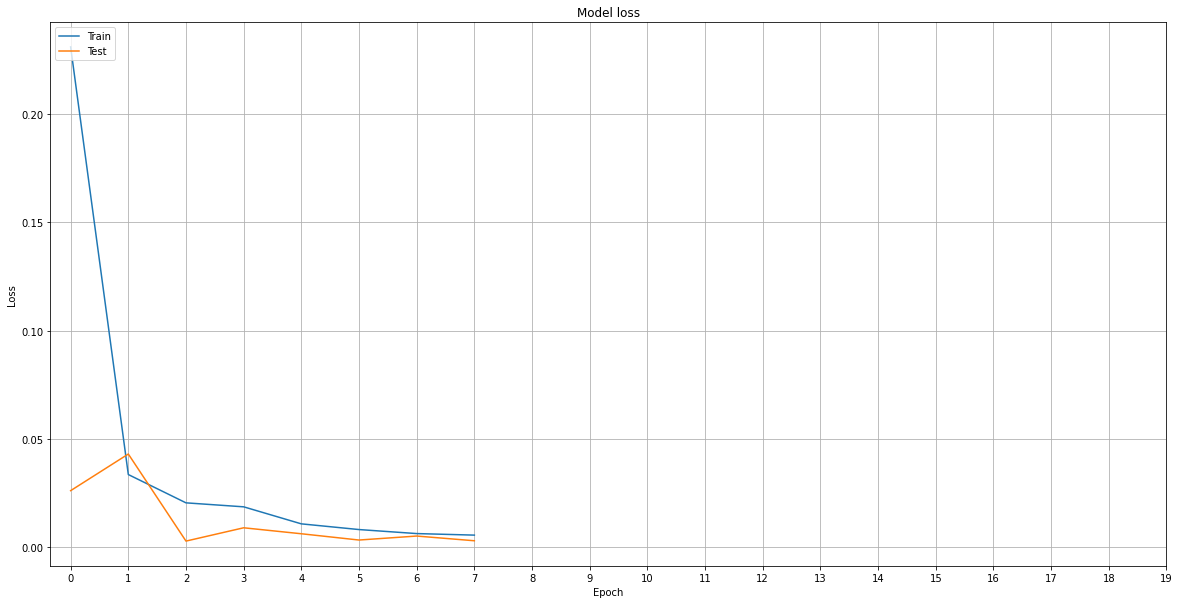

In [13]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [14]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 2.43
Mean Absolute Percentage Error (MAPE): 6.87 %
Median Absolute Percentage Error (MDAPE): 4.66 %


,MAE,MAPE,MDAPE
0,2.42838,6.87108,4.655562


In [15]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

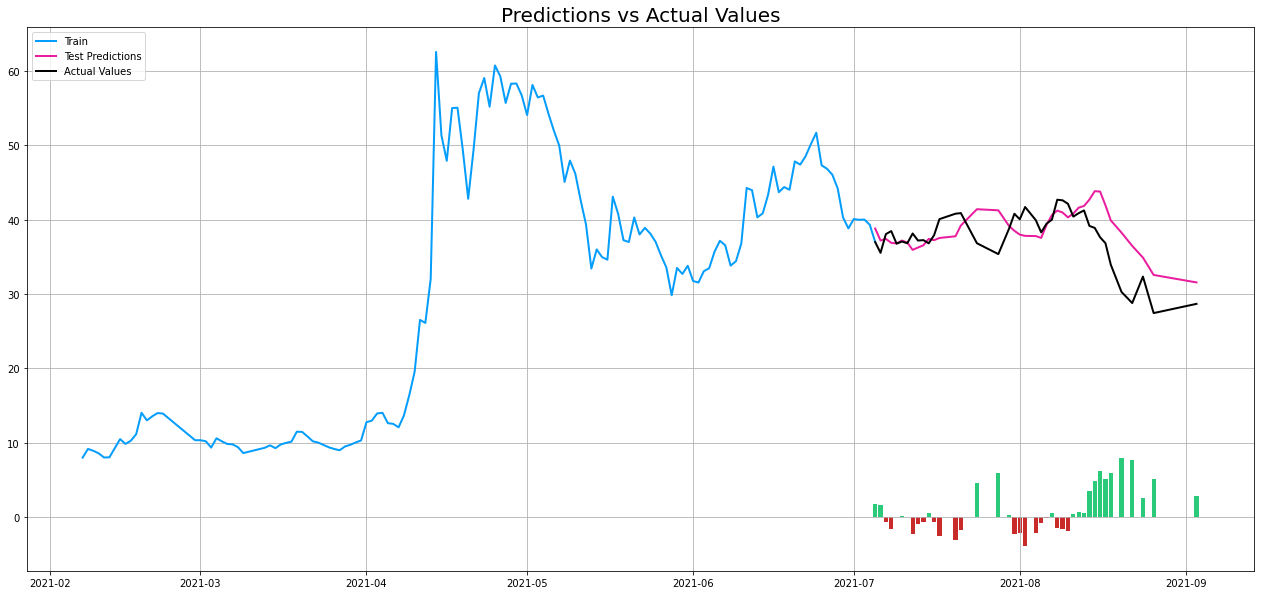

In [16]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [17]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '7D%Change', 'SD_log', 'SD', '6Dir', 'Open', '5Dir', 'Low', 'High', '4Dir', 'Dir', '3Dir', '2D%Change', 'Daily%Change', '6D%Change', 'Volume', '3D%Change', '2Dir', '4D%Change', '7Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,3Dir(t-4),2D%Change(t-4),Daily%Change(t-4),6D%Change(t-4),Volume(t-4),3D%Change(t-4),2Dir(t-4),4D%Change(t-4),7Dir(t-4),Close(t-4)
13,3.51,4,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,1.0,6.880727,6.880727,13.658536,162356400.0,1.746723,1.0,5.909085,1.0,2.33
14,4.42,0,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,1.0,40.366966,31.330474,42.990645,256276000.0,40.366966,1.0,33.624454,1.0,3.06
15,4.96,1,10.0,7.0,17.0,41.176228,18.0,9.0,-77.777778,14.0,...,1.0,27.467817,-2.941174,34.999998,181862200.0,36.238529,1.0,36.238529,1.0,2.97
16,19.90,2,13.0,6.0,19.0,31.578781,23.0,11.5,62.500000,13.0,...,1.0,-2.614377,0.336700,30.131007,64823800.0,27.897001,0.0,36.697244,1.0,2.98
17,8.63,3,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,1.0,18.181817,17.785234,61.009169,268273400.0,14.705884,1.0,50.643781,1.0,3.51


In [18]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,2D%Change(t-4),Daily%Change(t-4),6D%Change(t-4),Volume(t-4),3D%Change(t-4),2Dir(t-4),4D%Change(t-4),7Dir(t-4),Close(t-4),Prediction
232,29.010000,4,4.0,1.0,5.0,19.999600,6.0,3.0,0.0,2.0,...,-5.271276,-2.099391,-8.834446,24063800.0,-5.924412,0.0,-10.669256,0.0,36.840000,29.010000
235,32.349998,2,202.0,25.0,227.0,11.013211,202.0,101.0,100.0,26.0,...,-10.783730,5.985303,-22.676198,54901300.0,-17.806730,0.0,-19.532289,0.0,30.280001,32.349998
236,29.459999,3,24.0,8.0,32.0,24.999922,226.0,113.0,100.0,33.0,...,1.540079,-4.194189,-25.404987,66188600.0,-14.525629,1.0,-21.254071,0.0,29.010000,29.459999
238,23.240000,0,370.0,114.0,484.0,23.553714,371.0,185.5,36900.0,114.0,...,6.997589,7.815213,-15.743755,47927100.0,2.509908,1.0,8.645437,0.0,31.040001,23.240000
239,24.500000,1,224.0,58.0,282.0,20.567369,594.0,297.0,22300.0,172.0,...,12.365396,4.220353,-4.684738,46241500.0,11.513265,1.0,6.836188,0.0,32.349998,24.500000


In [19]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(162, 100)
(47, 100)


In [20]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(155, 7, 100) (155,)
(40, 7, 100) (40,)
0.073001359014186
0.073001359014186


In [21]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4052
Epoch 1: val_loss improved from inf to 0.01830, saving model to AMC_Close_4shift_Sentiment.h5
10/10 [==============================] - 7s 366ms/step - loss: 0.4052 - val_loss: 0.0183
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0616
Epoch 2: val_loss did not improve from 0.01830
10/10 [==============================] - 2s 249ms/step - loss: 0.0616 - val_loss: 0.0766
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0353
Epoch 3: val_loss did not improve from 0.01830
10/10 [==============================] - 2s 249ms/step - loss: 0.0353 - val_loss: 0.0220
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0177
Epoch 4: val_loss improved from 0.01830 to 0.01110, saving model to AMC_Close_4shift_Sentiment.h5
10/10 [==============================] - 3s 272ms/step - loss: 0.0177 - val_loss: 0.0111
Epoch 5/100
10/10 [==============================] - E

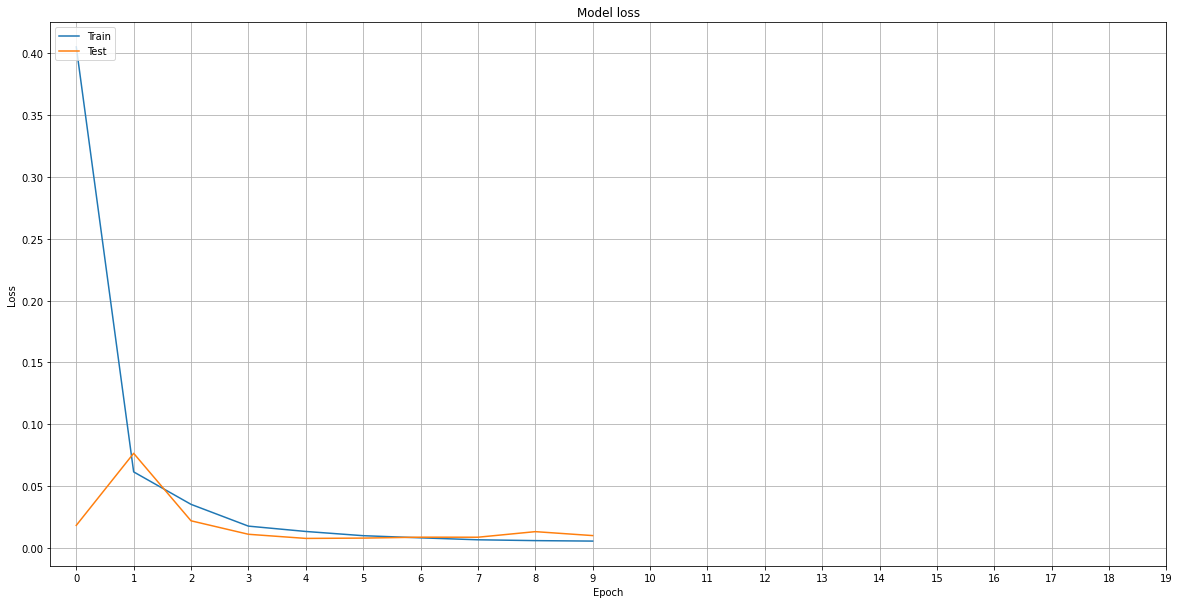

In [23]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 4.3
Mean Absolute Percentage Error (MAPE): 12.43 %
Median Absolute Percentage Error (MDAPE): 8.74 %


,MAE,MAPE,MDAPE
0,4.298766,12.433227,8.739939


In [25]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

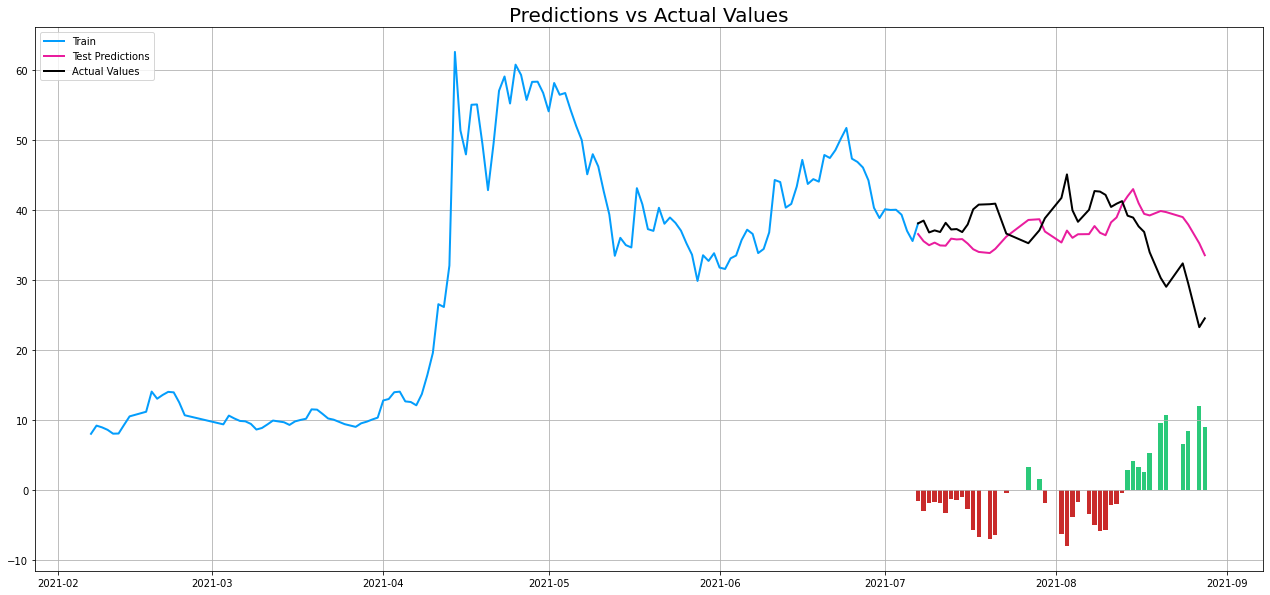

In [26]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [27]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '7D%Change', 'SD_log', 'SD', '6Dir', 'Open', '5Dir', 'Low', 'High', '4Dir', 'Dir', '3Dir', '2D%Change', 'Daily%Change', '6D%Change', 'Volume', '3D%Change', '2Dir', '4D%Change', '7Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,3Dir(t-7),2D%Change(t-7),Daily%Change(t-7),6D%Change(t-7),Volume(t-7),3D%Change(t-7),2Dir(t-7),4D%Change(t-7),7Dir(t-7),Close(t-7)
14,4.42,0,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,1.0,-0.909090,-4.803489,10.101012,45847700.0,1.869157,0.0,6.341469,1.0,2.18
15,4.96,1,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,0.0,-4.803489,0.000000,8.457715,49638800.0,-0.909090,0.0,1.869157,1.0,2.18
16,19.90,2,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,1.0,6.880727,6.880727,13.658536,162356400.0,1.746723,1.0,5.909085,1.0,2.33
17,8.63,3,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,1.0,40.366966,31.330474,42.990645,256276000.0,40.366966,1.0,33.624454,1.0,3.06
18,13.26,4,10.0,7.0,17.0,41.176228,18.0,9.0,-77.777778,14.0,...,1.0,27.467817,-2.941174,34.999998,181862200.0,36.238529,1.0,36.238529,1.0,2.97


In [28]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,2D%Change(t-7),Daily%Change(t-7),6D%Change(t-7),Volume(t-7),3D%Change(t-7),2Dir(t-7),4D%Change(t-7),7Dir(t-7),Close(t-7),Prediction
235,32.349998,2,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,-5.271276,-2.099391,-8.834446,24063800.0,-5.924412,0.0,-10.669256,0.0,36.840000,32.349998
239,24.500000,1,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,1.540079,-4.194189,-25.404987,66188600.0,-14.525629,1.0,-21.254071,0.0,29.010000,24.500000
241,24.450001,3,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,6.997589,7.815213,-15.743755,47927100.0,2.509908,1.0,8.645437,0.0,31.040001,24.450001
242,29.120001,4,224.0,58.0,282.0,20.567369,594.0,297.0,22300.000000,172.0,...,12.365396,4.220353,-4.684738,46241500.0,11.513265,1.0,6.836188,0.0,32.349998,29.120001
248,27.719999,1,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,-0.204079,-0.851578,-24.420396,43702400.0,5.206545,0.0,-10.896500,0.0,24.450001,27.719999


In [29]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(169, 100)
(49, 100)


In [30]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(162, 7, 100) (162,)
(42, 7, 100) (42,)
0.07827284115644323
0.07827284115644323


In [31]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.6554
Epoch 1: val_loss improved from inf to 0.01231, saving model to AMC_Close_7shift_Sentiment.h5
11/11 [==============================] - 7s 364ms/step - loss: 0.6554 - val_loss: 0.0123
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0386
Epoch 2: val_loss did not improve from 0.01231
11/11 [==============================] - 3s 260ms/step - loss: 0.0386 - val_loss: 0.0150
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0196
Epoch 3: val_loss improved from 0.01231 to 0.01040, saving model to AMC_Close_7shift_Sentiment.h5
11/11 [==============================] - 3s 287ms/step - loss: 0.0196 - val_loss: 0.0104
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0141
Epoch 4: val_loss did not improve from 0.01040
11/11 [==============================] - 3s 261ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 5/100
11/11 [==============================] - E

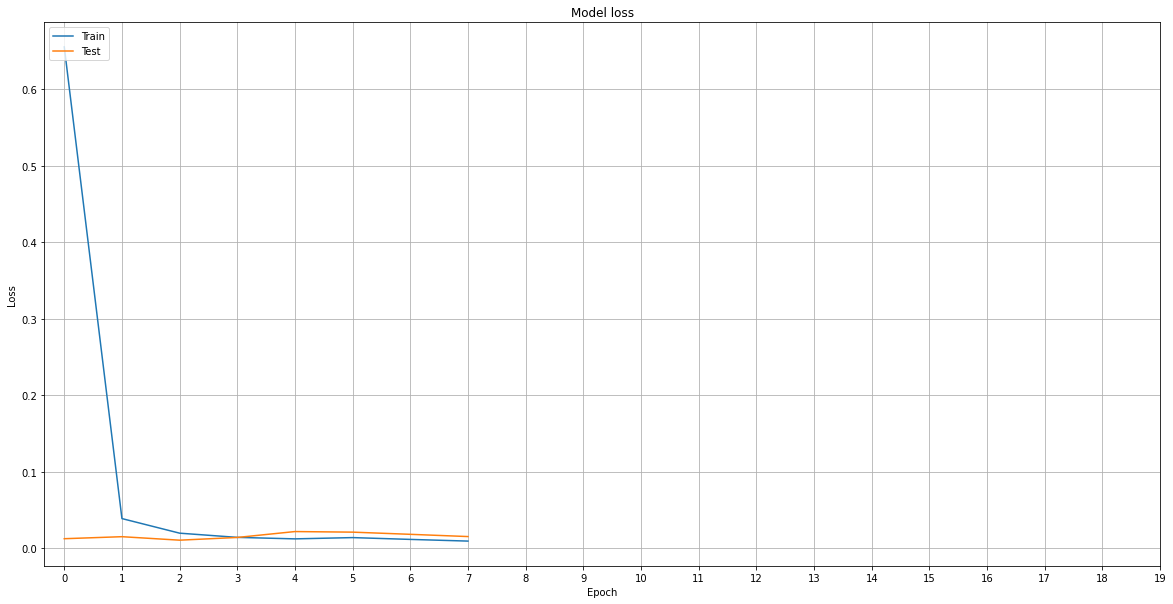

In [33]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 5.48
Mean Absolute Percentage Error (MAPE): 15.64 %
Median Absolute Percentage Error (MDAPE): 14.09 %


,MAE,MAPE,MDAPE
0,5.483434,15.641421,14.091451


In [35]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

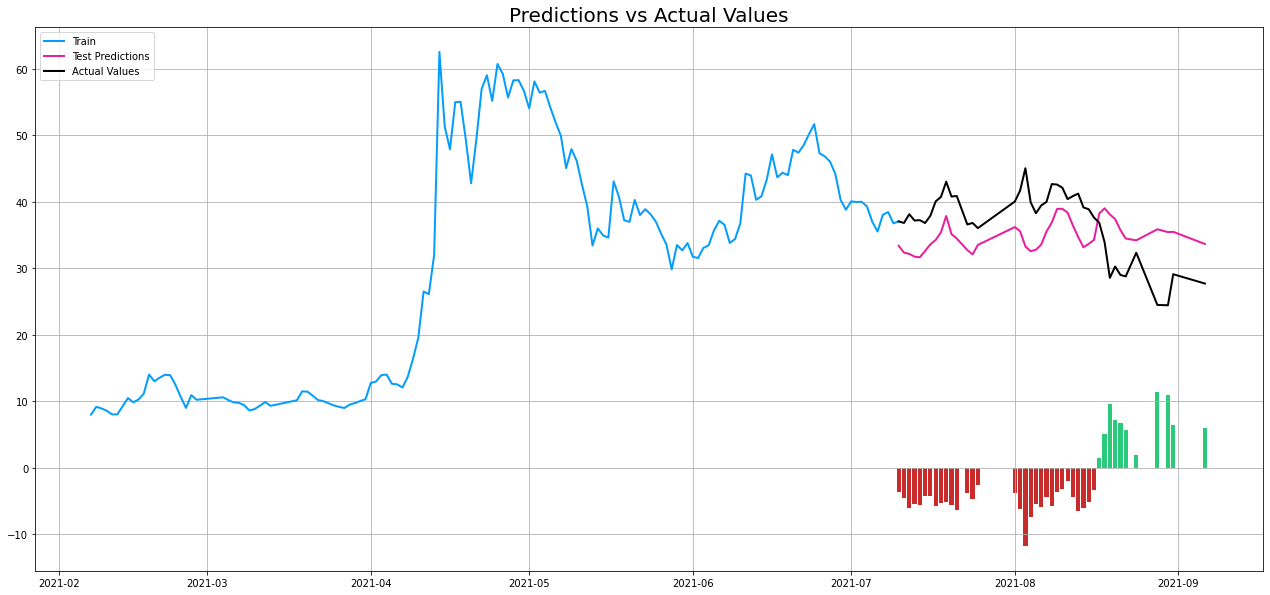

In [36]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [37]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '7D%Change', 'SD_log', 'SD', '6Dir', 'Open', '5Dir', 'Low', 'High', '4Dir', 'Dir', '3Dir', '2D%Change', 'Daily%Change', '6D%Change', 'Volume', '3D%Change', '2Dir', '4D%Change', '7Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,3Dir(t-1),2D%Change(t-1),Daily%Change(t-1),6D%Change(t-1),Volume(t-1),3D%Change(t-1),2Dir(t-1),4D%Change(t-1),7Dir(t-1),Close(t-1)
9,2.33,4,1.0,1.0,0.5,100.000000,1.0,0.333333,100.000000,1.0,...,0.0,-4.803489,0.000000,8.457715,49638800.0,-0.909090,0.0,1.869157,1.0,2.18
10,3.06,1,152.0,152.0,76.0,100.000000,152.0,50.666667,15100.000000,153.0,...,1.0,6.880727,6.880727,13.658536,162356400.0,1.746723,1.0,5.909085,1.0,2.33
11,2.97,2,102.0,254.0,127.0,100.000000,254.0,84.666667,100.000000,254.0,...,1.0,40.366966,31.330474,42.990645,256276000.0,40.366966,1.0,33.624454,1.0,3.06
12,2.98,3,73.0,175.0,87.5,-51.973684,327.0,109.000000,100.000000,327.0,...,1.0,27.467817,-2.941174,34.999998,181862200.0,36.238529,1.0,36.238529,1.0,2.97
13,3.51,4,15.0,88.0,44.0,-85.294118,190.0,63.333333,-90.131579,342.0,...,1.0,-2.614377,0.336700,30.131007,64823800.0,27.897001,0.0,36.697244,1.0,2.98


In [38]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,2D%Change(t-1),Daily%Change(t-1),6D%Change(t-1),Volume(t-1),3D%Change(t-1),2Dir(t-1),4D%Change(t-1),7Dir(t-1),Close(t-1),Prediction
239,24.500000,1,12.0,12.0,6.0,100.000000,12.0,4.000000,-95.744681,294.0,...,-21.113372,-15.306125,-19.889695,84199800.0,-28.160739,0.0,-25.128869,0.0,23.240000,24.500000
240,24.660000,2,3.0,15.0,7.5,100.000000,15.0,5.000000,100.000000,15.0,...,-10.714287,5.421688,-14.901010,107045800.0,-16.836386,0.0,-24.265839,0.0,24.500000,24.660000
241,24.450001,3,1.0,4.0,2.0,-91.666667,16.0,5.333333,100.000000,16.0,...,6.110155,0.653061,-20.554127,53208200.0,-10.131198,1.0,-16.293277,0.0,24.660000,24.450001
245,28.680000,2,5.0,5.0,2.5,100.000000,5.0,1.666667,400.000000,6.0,...,4.052192,2.020197,30.378655,46852500.0,23.926373,1.0,22.871044,1.0,30.299999,28.680000
246,28.520000,3,3.0,8.0,4.0,100.000000,8.0,2.666667,100.000000,8.0,...,-3.434345,-5.346531,17.061226,36983800.0,-1.510991,0.0,17.300611,1.0,28.680000,28.520000


In [39]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(179, 43)
(51, 43)


In [40]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(172, 7, 43) (172,)
(44, 7, 43) (44,)
0.29176353196882
0.29176353196882


In [41]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0785
Epoch 1: val_loss improved from inf to 0.01961, saving model to AMC_Close_1shift_Baseline.h5
11/11 [==============================] - 5s 163ms/step - loss: 0.0785 - val_loss: 0.0196
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0135
Epoch 2: val_loss improved from 0.01961 to 0.01287, saving model to AMC_Close_1shift_Baseline.h5
11/11 [==============================] - 1s 76ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0088
Epoch 3: val_loss improved from 0.01287 to 0.00471, saving model to AMC_Close_1shift_Baseline.h5
11/11 [==============================] - 1s 78ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0073
Epoch 4: val_loss improved from 0.00471 to 0.00448, saving model to AMC_Close_1shift_Baseline.h5
11/11 [==============================] - 1s 137

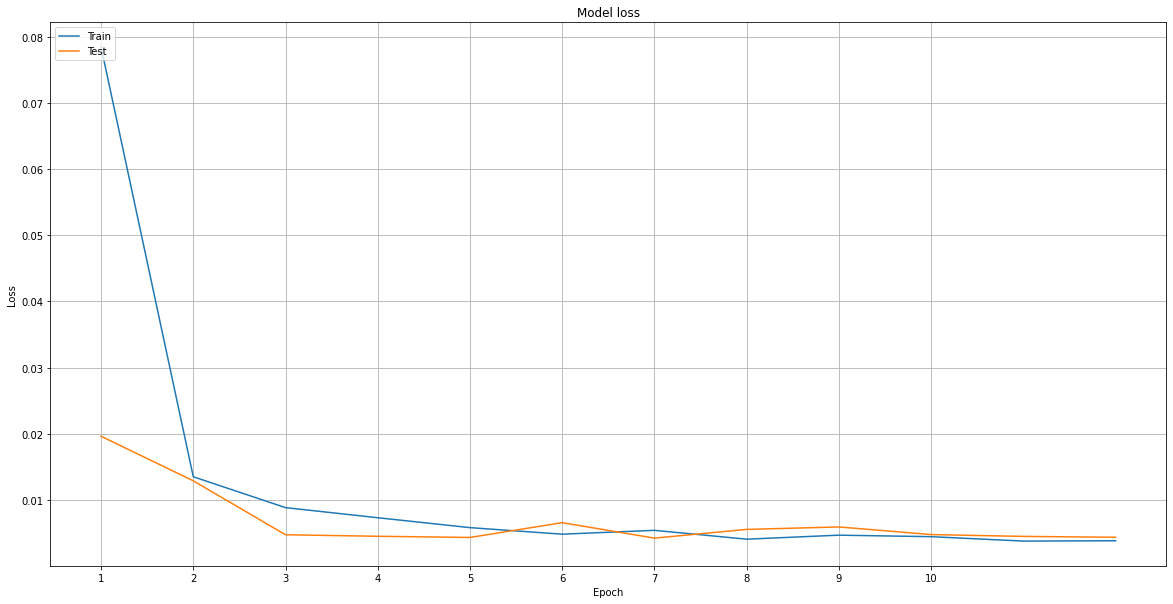

In [43]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [44]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 3.14
Mean Absolute Percentage Error (MAPE): 9.25 %
Median Absolute Percentage Error (MDAPE): 8.05 %


,MAE,MAPE,MDAPE
0,3.141724,9.252387,8.045224


In [45]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

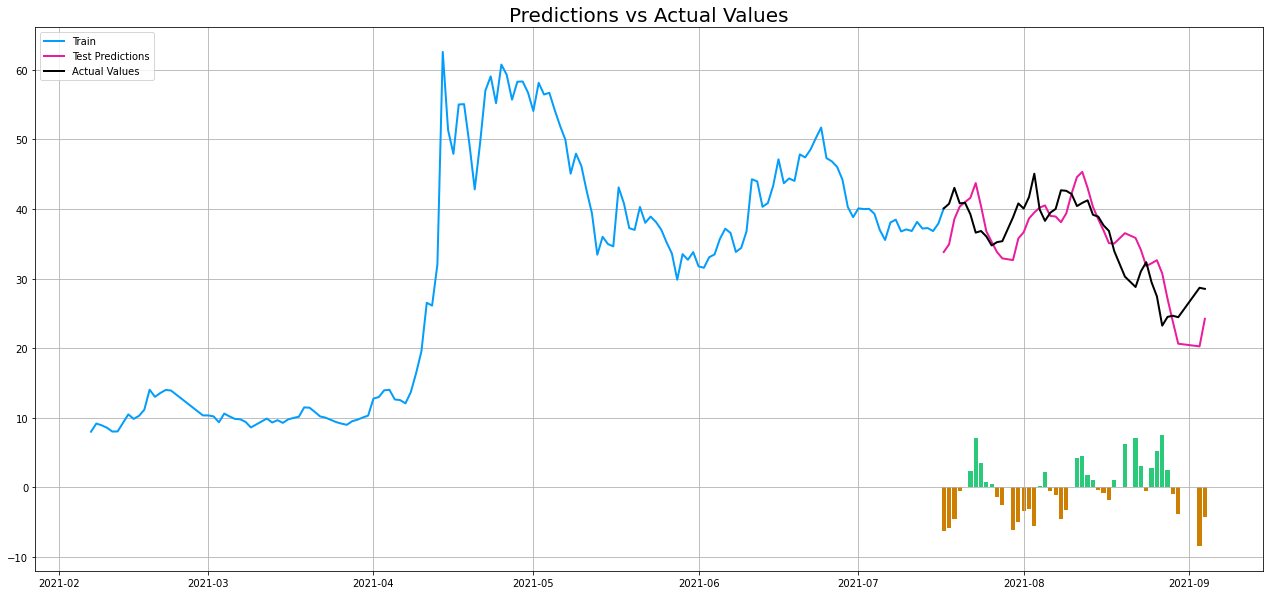

In [46]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [47]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '7D%Change', 'SD_log', 'SD', '6Dir', 'Open', '5Dir', 'Low', 'High', '4Dir', 'Dir', '3Dir', '2D%Change', 'Daily%Change', '6D%Change', 'Volume', '3D%Change', '2Dir', '4D%Change', '7Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,3Dir(t-4),2D%Change(t-4),Daily%Change(t-4),6D%Change(t-4),Volume(t-4),3D%Change(t-4),2Dir(t-4),4D%Change(t-4),7Dir(t-4),Close(t-4)
10,3.06,1,1.0,2.0,1.0,100.000000,2.0,0.666667,100.000000,2.0,...,1.0,7.009339,4.090905,13.930347,41549200.0,11.707318,1.0,13.930347,1.0,2.29
13,3.51,4,152.0,152.0,76.0,100.000000,152.0,50.666667,15100.000000,153.0,...,1.0,6.880727,6.880727,13.658536,162356400.0,1.746723,1.0,5.909085,1.0,2.33
14,4.42,0,15.0,88.0,44.0,-85.294118,190.0,63.333333,-90.131579,342.0,...,1.0,40.366966,31.330474,42.990645,256276000.0,40.366966,1.0,33.624454,1.0,3.06
15,4.96,1,17.0,32.0,16.0,-76.712329,105.0,35.000000,-83.333333,207.0,...,1.0,27.467817,-2.941174,34.999998,181862200.0,36.238529,1.0,36.238529,1.0,2.97
16,19.90,2,19.0,36.0,18.0,26.666667,51.0,17.000000,-73.972603,124.0,...,1.0,-2.614377,0.336700,30.131007,64823800.0,27.897001,0.0,36.697244,1.0,2.98


In [48]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,2D%Change(t-4),Daily%Change(t-4),6D%Change(t-4),Volume(t-4),3D%Change(t-4),2Dir(t-4),4D%Change(t-4),7Dir(t-4),Close(t-4),Prediction
241,24.450001,3,0.0,0.0,0.0,-100.0,282.0,94.000000,-100.000000,766.0,...,-15.177738,-6.856750,-9.379128,58858900.0,-11.597939,0.0,-4.689129,0.0,27.440001,24.450001
242,29.120001,4,12.0,12.0,6.0,100.0,12.0,4.000000,-95.744681,294.0,...,-21.113372,-15.306125,-19.889695,84199800.0,-28.160739,0.0,-25.128869,0.0,23.240000,29.120001
244,30.299999,1,2.0,2.0,1.0,100.0,3.0,1.000000,-33.333333,6.0,...,6.110155,0.653061,-20.554127,53208200.0,-10.131198,1.0,-16.293277,0.0,24.660000,30.299999
245,28.680000,2,1.0,3.0,1.5,100.0,3.0,1.000000,0.000000,4.0,...,-0.204079,-0.851578,-24.420396,43702400.0,5.206545,0.0,-10.896500,0.0,24.450001,28.680000
247,28.700001,0,2.0,5.0,2.5,-60.0,10.0,3.333333,100.000000,10.0,...,21.472392,1.991758,8.236152,66938200.0,20.437960,1.0,21.224493,1.0,29.700001,28.700001


In [49]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(177, 43)
(51, 43)


In [50]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(170, 7, 43) (170,)
(44, 7, 43) (44,)
0.17212977591915574
0.17212977591915574


In [51]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.1093
Epoch 1: val_loss improved from inf to 0.07028, saving model to AMC_Close_4shift_Baseline.h5
11/11 [==============================] - 6s 161ms/step - loss: 0.1093 - val_loss: 0.0703
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0266
Epoch 2: val_loss improved from 0.07028 to 0.00619, saving model to AMC_Close_4shift_Baseline.h5
11/11 [==============================] - 1s 75ms/step - loss: 0.0289 - val_loss: 0.0062
Epoch 3/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0148
Epoch 3: val_loss did not improve from 0.00619
11/11 [==============================] - 1s 66ms/step - loss: 0.0140 - val_loss: 0.0071
Epoch 4/100
10/11 [==========================>...] - ETA: 0s - loss: 0.0121
Epoch 4: val_loss did not improve from 0.00619
11/11 [==============================] - 1s 66ms/step - loss: 0.0121 - val_loss: 0.0137
Epoch 5/100
10/11 [==========================>...] - ETA: 0

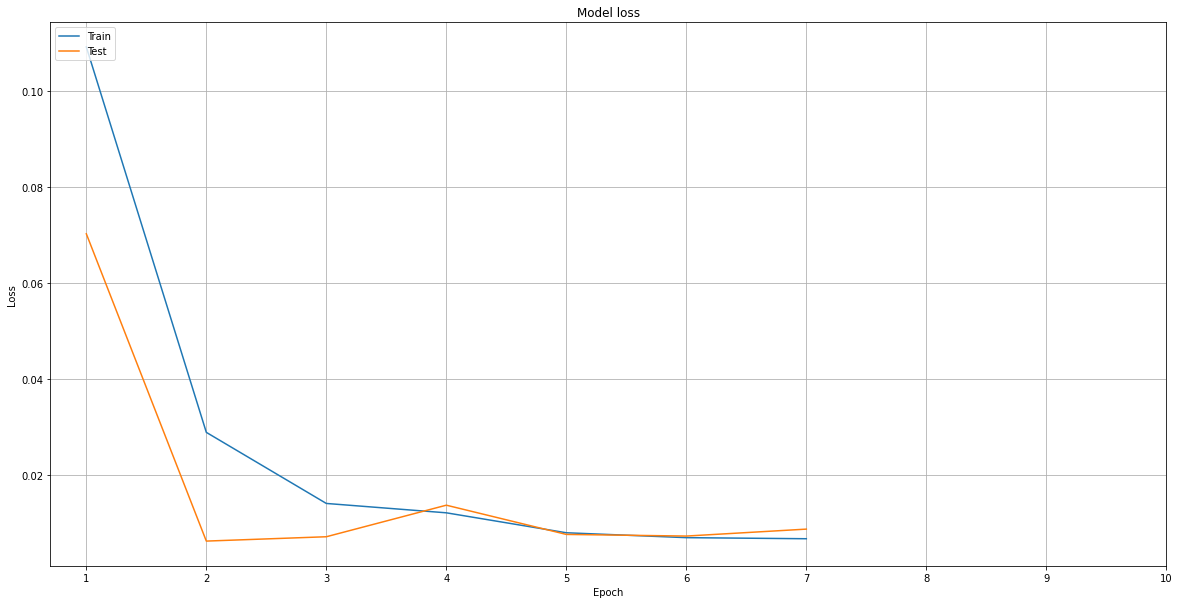

In [53]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [54]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 3.68
Mean Absolute Percentage Error (MAPE): 10.61 %
Median Absolute Percentage Error (MDAPE): 8.52 %


,MAE,MAPE,MDAPE
0,3.684538,10.606549,8.517405


In [55]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

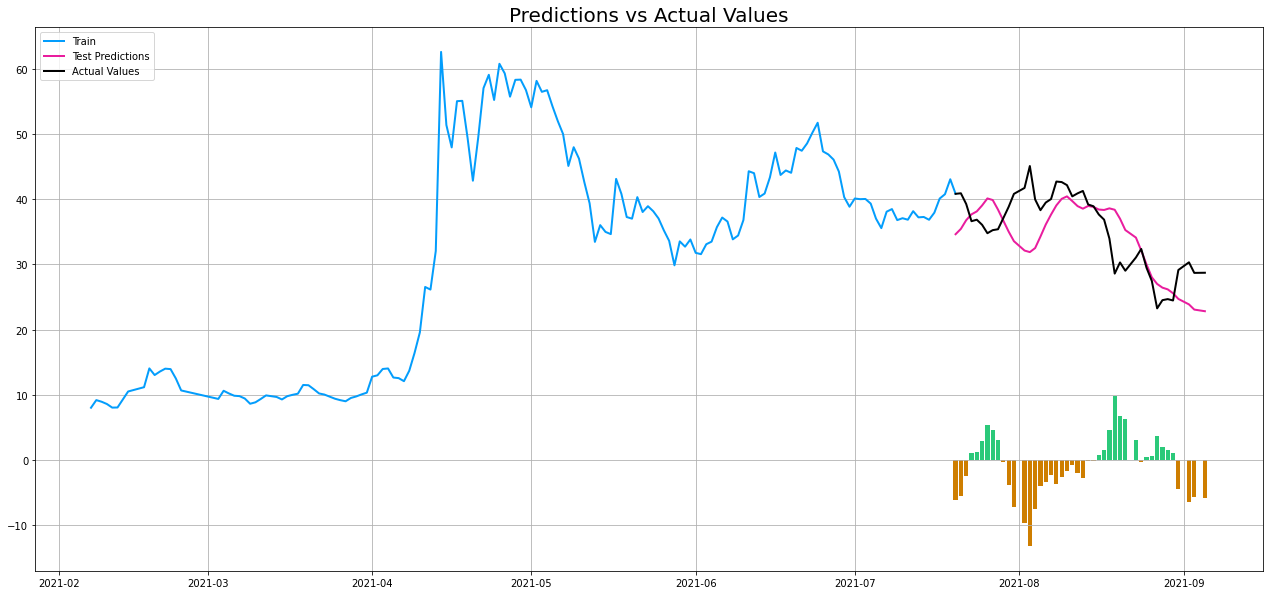

In [56]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [57]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '7D%Change', 'SD_log', 'SD', '6Dir', 'Open', '5Dir', 'Low', 'High', '4Dir', 'Dir', '3Dir', '2D%Change', 'Daily%Change', '6D%Change', 'Volume', '3D%Change', '2Dir', '4D%Change', '7Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,3Dir(t-7),2D%Change(t-7),Daily%Change(t-7),6D%Change(t-7),Volume(t-7),3D%Change(t-7),2Dir(t-7),4D%Change(t-7),7Dir(t-7),Close(t-7)
13,3.51,4,1.0,2.0,1.0,100.000000,2.0,0.666667,100.000000,2.0,...,1.0,7.009339,4.090905,13.930347,41549200.0,11.707318,1.0,13.930347,1.0,2.29
14,4.42,0,152.0,152.0,76.0,100.000000,152.0,50.666667,15100.000000,153.0,...,1.0,-0.909090,-4.803489,10.101012,45847700.0,1.869157,0.0,6.341469,1.0,2.18
15,4.96,1,102.0,254.0,127.0,100.000000,254.0,84.666667,100.000000,254.0,...,0.0,-4.803489,0.000000,8.457715,49638800.0,-0.909090,0.0,1.869157,1.0,2.18
16,19.90,2,73.0,175.0,87.5,-51.973684,327.0,109.000000,100.000000,327.0,...,1.0,6.880727,6.880727,13.658536,162356400.0,1.746723,1.0,5.909085,1.0,2.33
17,8.63,3,15.0,88.0,44.0,-85.294118,190.0,63.333333,-90.131579,342.0,...,1.0,40.366966,31.330474,42.990645,256276000.0,40.366966,1.0,33.624454,1.0,3.06


In [58]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,2D%Change(t-7),Daily%Change(t-7),6D%Change(t-7),Volume(t-7),3D%Change(t-7),2Dir(t-7),4D%Change(t-7),7Dir(t-7),Close(t-7),Prediction
243,29.700001,0,12.0,12.0,6.0,100.000000,12.0,4.000000,-95.744681,294.0,...,-5.090212,-8.933538,3.115154,36556800.0,2.327191,0.0,1.551185,0.0,29.459999,29.700001
244,30.299999,1,3.0,15.0,7.5,100.000000,15.0,5.000000,100.000000,15.0,...,-15.177738,-6.856750,-9.379128,58858900.0,-11.597939,0.0,-4.689129,0.0,27.440001,30.299999
245,28.680000,2,1.0,4.0,2.0,-91.666667,16.0,5.333333,100.000000,16.0,...,-21.113372,-15.306125,-19.889695,84199800.0,-28.160739,0.0,-25.128869,0.0,23.240000,28.680000
248,27.719999,1,5.0,5.0,2.5,100.000000,5.0,1.666667,400.000000,6.0,...,-0.204079,-0.851578,-24.420396,43702400.0,5.206545,0.0,-10.896500,0.0,24.450001,27.719999
249,27.950001,2,3.0,8.0,4.0,100.000000,8.0,2.666667,100.000000,8.0,...,18.085973,19.100204,-1.154101,144753100.0,18.857146,1.0,25.301210,0.0,29.120001,27.950001


In [59]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(182, 43)
(52, 43)


In [60]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(175, 7, 43) (175,)
(45, 7, 43) (45,)
0.073001359014186
0.073001359014186


In [61]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0720
Epoch 1: val_loss improved from inf to 0.00977, saving model to AMC_Close_7shift_Baseline.h5
11/11 [==============================] - 6s 159ms/step - loss: 0.0720 - val_loss: 0.0098
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0158
Epoch 2: val_loss improved from 0.00977 to 0.00789, saving model to AMC_Close_7shift_Baseline.h5
11/11 [==============================] - 1s 74ms/step - loss: 0.0158 - val_loss: 0.0079
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0099
Epoch 3: val_loss improved from 0.00789 to 0.00721, saving model to AMC_Close_7shift_Baseline.h5
11/11 [==============================] - 1s 74ms/step - loss: 0.0099 - val_loss: 0.0072
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0088
Epoch 4: val_loss improved from 0.00721 to 0.00680, saving model to AMC_Close_7shift_Baseline.h5
11/11 [==============================] - 1s 74m

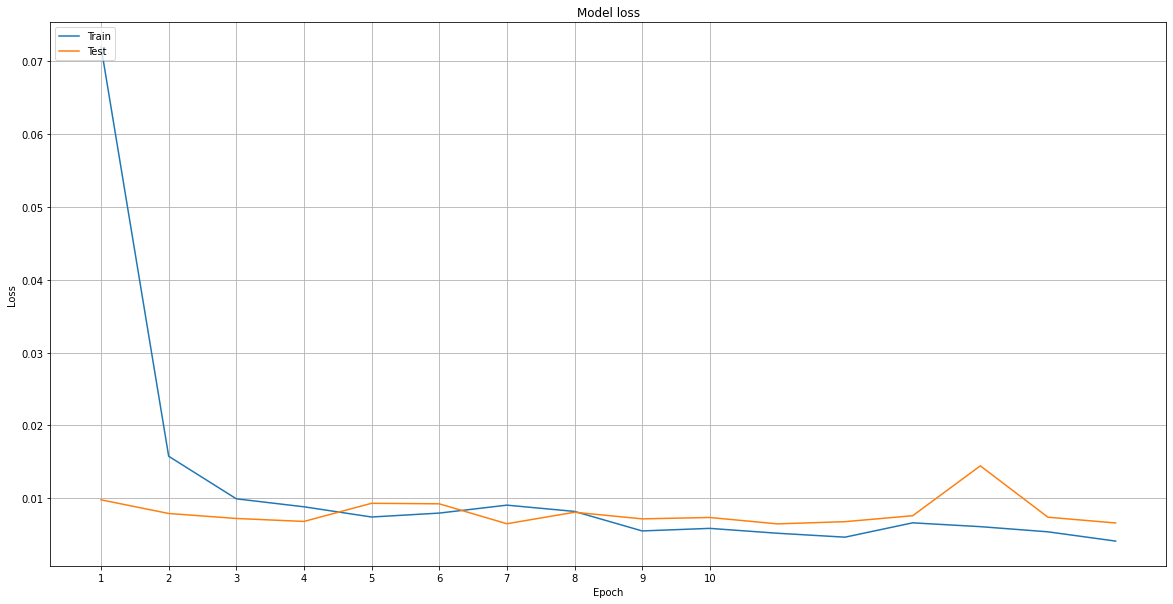

In [63]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [64]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 3.84
Mean Absolute Percentage Error (MAPE): 11.87 %
Median Absolute Percentage Error (MDAPE): 8.38 %


,MAE,MAPE,MDAPE
0,3.835562,11.872424,8.381714


In [65]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

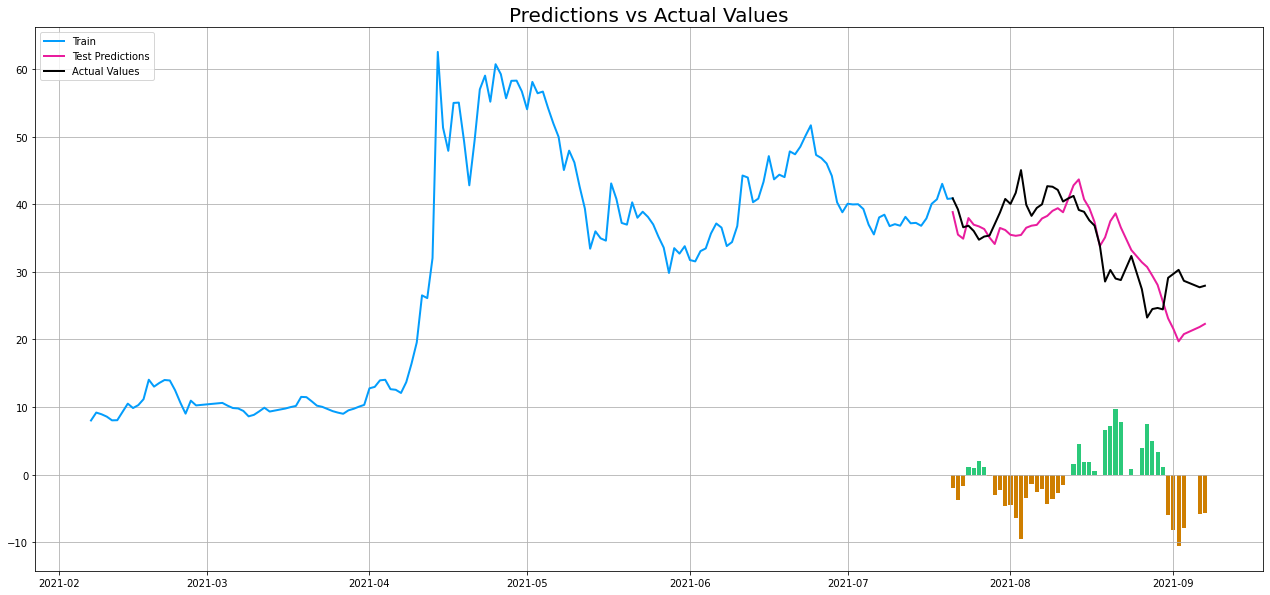

In [66]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## Overall Results

In [67]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,3.141724,2.428380
1,1dayshift,MAPE,9.252387,6.871080
2,1dayshift,MDAPE,8.045224,4.655562
3,4dayshift,MAE,3.684538,4.298766
4,4dayshift,MAPE,10.606549,12.433227
5,4dayshift,MDAPE,8.517405,8.739939
6,7dayshift,MAE,3.835562,5.483434
7,7dayshift,MAPE,11.872424,15.641421
8,7dayshift,MDAPE,8.381714,14.091451


In [68]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)